In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

from ipywidgets import interact
import ipywidgets as widgets
import numpy as np

import time

%matplotlib notebook
%matplotlib notebook

SIGMA = 10
B = 8.0 / 3.0
simulationTime = 30 # simulation time may change later

In [2]:
def differential(x, y, z, r):
    return np.array([
        -SIGMA * x + SIGMA * y,
        -x * z + r * x - y,
        x * y - B * z
    ])

In [3]:
def explicitEuler(pos, r, dt):
    return pos + dt * differential(*pos, r)

In [6]:
from scipy import optimize

def implicitEquation(pos1, pos0, r, dt):
    return (pos1 - pos0) / dt - (differential(*pos0, r) + differential(*pos1, r)) / 2

def implicitEuler(pos, r, dt):
    optimized = optimize.root(implicitEquation, pos, args=(pos, r, dt))
    return optimized.x

In [7]:
def rungeKutta(pos, r, dt):
    k1 = differential(*pos, r)
    k2 = differential(*(pos + 0.5 * dt * k1), r)
    k3 = differential(*(pos + 0.5 * dt * k2), r)
    k4 = differential(*(pos + 1.0 * dt * k3), r)
    return pos + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [8]:
def predictorCorrector(pos, r, dt):
    d0 = differential(*pos, r)
    prediction = pos + dt * d0
    for i in range(6):
        d1 = differential(*prediction, r)
        prediction = pos + dt * (d0 + d1) / 2
    return prediction

In [9]:
def solve(pos, r, dt, methodStep):
    cnt = int(simulationTime / dt)
    xs = np.zeros(cnt)
    ys = np.zeros(cnt)
    zs = np.zeros(cnt)
    
    for i in range(cnt):
        xs[i] = pos[0]
        ys[i] = pos[1]
        zs[i] = pos[2]
        pos = methodStep(pos, r, dt)
    
    return xs, ys, zs

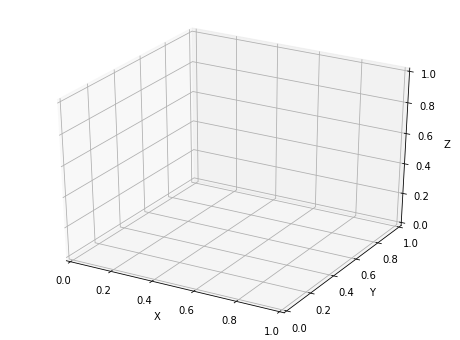

interactive(children=(SelectMultiple(description='Methods:', index=(0, 1, 2, 3), options=('explicitEuler', 'im…

In [10]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def interactiveSinglePoint():
    
    plotMode = widgets.ToggleButtons(
        options=['XYZ', 'XYZT', 'XT', 'YT', 'ZT']
    )
    
    methods = widgets.SelectMultiple(
        options=['explicitEuler', 'implicitEuler', 'rungeKutta', 'predictorCorrector'],
        value=['explicitEuler', 'implicitEuler', 'rungeKutta', 'predictorCorrector'],
        description='Methods:',
        disabled=False
    )

    r = widgets.FloatLogSlider(
        value=10,
        base=10,
        min=-1,
        max=3,
        step=0.1,
        description='r',
        continuous_update=False
    )

    dt = widgets.FloatLogSlider(
        value=0.01,
        base=10,
        min=-3,
        max=-1,
        step=0.1,
        description='dt',
        continuous_update=False
    )

    totalTime = widgets.FloatSlider(
        value=30,
        min=1,
        max=40,
        description='simulationTime',
        continuous_update=False
    )
    
    fig = plt.figure(2, figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

    def update(enabledMethods, r, dt, totalTime, plotMode):
        ax.clear()
        global simulationTime
        simulationTime = totalTime

        pos = np.array([1.01, 1.0, 1.0])

        methodsAndColors = {explicitEuler:'pink', implicitEuler:'red', rungeKutta:'green', predictorCorrector:'blue'}    
        
        print(plotMode)

        for method, color in methodsAndColors.items():
            if method.__name__ in enabledMethods:
                x, y, z = solve(pos, r, dt, method)
                n = len(x)
                t = np.linspace(0, simulationTime, n)
                if 'XYZ' == plotMode:
                    ax.plot(x, y, z, c=color, alpha=0.9, linewidth=1)
                if 'XT' == plotMode:
                    ax.plot(t, np.zeros(n), x, c=color, alpha=0.9, linewidth=1)
                if 'YT' == plotMode:
                    ax.plot(t, np.zeros(n), y, c=color, alpha=0.9, linewidth=1)
                if 'ZT' == plotMode:
                    ax.plot(t, np.zeros(n), z, c=color, alpha=0.9, linewidth=1)
                if 'XYZT' == plotMode:
                    zz = z / np.sqrt(2)
                    ax.plot(t, np.zeros(n), y, c=color, alpha=0.9, linewidth=1)
                    ax.plot(t, x, np.zeros(n), c=color, alpha=0.9, linewidth=1)
                    ax.plot(t, zz, z, c=color, alpha=0.9, linewidth=1)

    w = interactive(update, enabledMethods=methods, r=r, dt=dt, totalTime=totalTime, plotMode=plotMode)
    display(w)
    
interactiveSinglePoint()

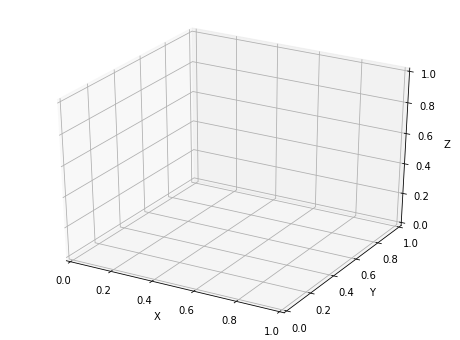

interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='r', max=3.0, min=-1.0), …

In [11]:
def interactiveGrid():
    r = widgets.FloatLogSlider(
        value=1,
        base=10,
        min=-1,
        max=3,
        step=0.1,
        description='r',
        continuous_update=False
    )

    dt = widgets.FloatLogSlider(
        value=0.01,
        base=10,
        min=-5,
        max=-1,
        step=0.1,
        description='dt',
        continuous_update=False
    )

    totalTime = widgets.FloatSlider(
        value=10,
        min=0.01,
        max=30,
        description='simulationTime',
        continuous_update=False
    )
    
    resolution = widgets.IntSlider(
        value=5,
        min=1,
        max=30,
        description='resolution',
        continuous_update=False
    )
    
    opacity = widgets.FloatSlider(
        value=0.2,
        min=0.0001,
        max=0.4,
        description='opacity',
        step=0.0001,
        continuous_update=False
    )
    
    fig = plt.figure(3, figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

    def runManyPoints(r, dt, totalTime, gridResolution = 5, alpha = 0.2): 
        global simulationTime
        simulationTime = totalTime

        ax.clear()       

        x = np.linspace(-10, 20.0, gridResolution)
        y = np.linspace(-10, 20.0, gridResolution)
        z = np.linspace(-10, 20.0, gridResolution)
        xv, yv, zv = np.meshgrid(x, y, z)

        for idX in range(len(xv)):
            for idY in range(len(yv)):
                for idZ in range(len(yv)):
                    pos = np.array([
                        xv[idX][idY][idZ], 
                        yv[idX][idY][idZ], 
                        zv[idX][idY][idZ]
                    ])
                    x, y, z = solve(pos, r, dt, rungeKutta)
                    n = len(x)
                    ax.plot(x, y, z, c='red', alpha=alpha, linewidth=1)
    
    w = interactive(runManyPoints, r=r, dt=dt, totalTime=totalTime, gridResolution=resolution, alpha=opacity)
    display(w)
    
interactiveGrid()